Much like AutoRegressive Integrated Moving Average (ARIMA) forecasting we can use a Additive Regression method utilizing Bayesian Inference called Prophet.This proedure contains three components we will utilize: a piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
A yearly seasonal component modeled using Fourier series.
A weekly seasonal component using dummy variables. Underneath the hood Prophet uses Stan and Stan performs the MAP optimization for parameters extremely quickly (<1 second), gives us the option to estimate parameter uncertainty using the Hamiltonian Monte Carlo algorithm, and allows us to re-use the fitting procedure across multiple interface languages including Python and R.
Credit to the Core Facebook Datascience Team and Andrew Gelman (Columbia Univeristy).http://andrewgelman.com/2017/03/01/facebooks-prophet-uses-stan/


One of the problems with time series forecasting using ARIMA models is the requirement that the data have been observed at a regular interval. Missing data requires imputation, which can introduce additional error in forecasts. Facebook's Prophet model gets around this treating time series modeling as a piecewise-curve fitting problem. By not explicitly accounting for the temporal aspect of the data, missing data or irregular sampling intervals are irrelevant. As with most computational methods, this advantage comes at the expense being able to use the time lag structure associated with ARIMA model for inference. They adopt an additive modeling approach.
Prophet applies a Gaussian smoothing prior to smooth out the seasonal behavior. The holiday behavior is modeled using an indicator function which is 1 if the day is a holiday, 0 otherwise. As with seasonality, a smoothing prior is applied (Volzer).https://content.nexosis.com/blog/methods-of-demand-forecasting-bsts-prophet

In [130]:
# Price Correlation between oil and pcar using price fluctuations over the last 5 years.

%matplotlib inline 
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import os
import numpy as np
plt.style.use("fivethirtyeight")


In [132]:
df = pd.read_csv('Data/UGA.csv')
df_pcar = pd.read_csv('Data/PCAR.csv')

df.tail(5)
# os.chdir('..')

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2017-12-06,30.719999,30.719999,29.910000,30.070000,30.070000,24100
1255,2017-12-07,30.190001,30.660000,30.120001,30.629999,30.629999,21800
1256,2017-12-08,30.980000,31.250000,30.770000,30.950001,30.950001,38700
1257,2017-12-11,31.040001,31.320000,30.950001,31.110001,31.110001,31300
1258,2017-12-12,31.400000,31.400000,30.500000,30.600000,30.600000,23100


In [133]:
df['Date'] = pd.DatetimeIndex(df['Date'])
df_pcar['Date'] = pd.DatetimeIndex(df_pcar['Date'])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [170]:
df = df.rename(columns={'Date': 'ds',
                        'Adj Close': 'y'})
df_pcar = df_pcar.rename(columns={'Date': 'ds',
                        'Adj Close': 'y'})
df['y'] = np.log(df['y'])
df_pcar['y'] = np.log(df_pcar['y'])
df.tail(5)

,ds,Open,High,Low,Close,y,Volume
1254,2017-12-06,30.719999,30.719999,29.910000,30.070000,-1.595595,24100
1255,2017-12-07,30.190001,30.660000,30.120001,30.629999,-1.574107,21800
1256,2017-12-08,30.980000,31.250000,30.770000,30.950001,-1.562294,38700
1257,2017-12-11,31.040001,31.320000,30.950001,31.110001,-1.556509,31300
1258,2017-12-12,31.400000,31.400000,30.500000,30.600000,-1.575232,23100


In [171]:
# ax = df.set_index('ds').plot(df['ds'], df['y'], figsize=(12, 8))
# ax.set_ylabel('PCAR')
# ax.set_xlabel('Date')

# plt.show()
df_pcar

,ds,Open,High,Low,Close,y,Volume
0,2012-12-13,44.630001,44.810001,43.840000,43.900002,3.636580,2048300
1,2012-12-14,44.009998,44.450001,43.860001,43.910000,3.636808,1974800
2,2012-12-17,44.169998,44.349998,43.840000,44.310001,3.645876,1964300
3,2012-12-18,44.450001,45.000000,44.290001,44.980000,3.660883,2025300
4,2012-12-19,44.900002,45.439999,44.669998,44.939999,3.659994,2348600
5,2012-12-20,45.040001,45.040001,44.549999,44.980000,3.660883,1895400
6,2012-12-21,43.889999,44.869999,43.669998,44.840000,3.657766,4044300
7,2012-12-24,44.910000,44.950001,44.340000,44.669998,3.653967,537400
8,2012-12-26,44.709999,45.150002,44.700001,44.770000,3.656204,1297900
9,2012-12-27,44.779999,44.889999,43.779999,44.619999,3.652848,1677500


In [172]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
# my_model = Prophet(interval_width=0.95)
my_model_pcar = Prophet(interval_width=0.95)

In [173]:
# my_model.fit(df)
my_model_pcar.fit(df_pcar)

In [174]:
# future_dates = my_model.make_future_dataframe(periods= 365)
# forecast_oil = my_model.predict(future_dates)
# forecast_oil[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
future_dates = my_model_pcar.make_future_dataframe(periods= 365)
forecast_pcar = my_model_pcar.predict(future_dates)
forecast_pcar[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1619,2018-12-08,4.430364,2.816028,5.840502
1620,2018-12-09,4.432057,2.806434,5.853268
1621,2018-12-10,4.428256,2.831837,5.863007
1622,2018-12-11,4.429695,2.805463,5.877097
1623,2018-12-12,4.432598,2.829975,5.888068


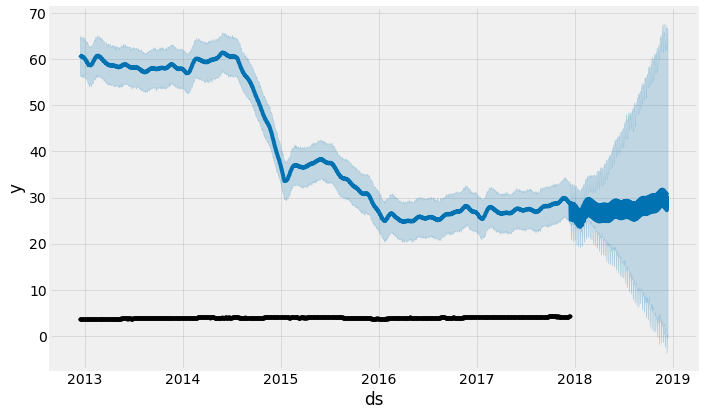

In [175]:
my_model_pcar.plot(forecast,
              uncertainty=True).savefig("Forecast_Bayesian_pcar", dpi = 2000)
#  yhat is the predicted value of y, in this case the stock price of PCAR.
# Since we are using Bayesian inference we get uncertainty intervals with our estimate and can be better than 
# point estimates that you get with deep learning based on the situation. 


We see a variation in values from the output presented, which is expected Prophet relies on Markov Chain Monte Carlo (MCMC) 
methods to generate its forecasts. MCMC is a probabilistic process, thus we get slightly different outputs each time 
we run the model.
The blue region is our 95% confidence interval.

Like all models, it is wrong but still useful.


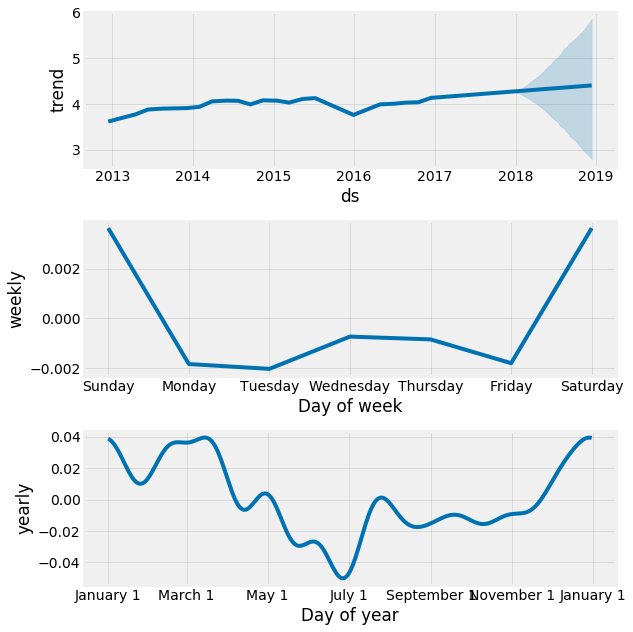

In [176]:
my_model_pcar.plot_components(forecast_pcar).savefig("subplots_oil", dpi = 2000)

These further disections of the price data are very interesing. Looking at the seasonality of pricing fluctuations.


In [177]:
forecast_oil

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
0,2012-12-13,0.000000,59.414657,1.481640,1.481640,59.414657,59.414657,57.077060,65.034095,1.065286,1.065286,1.065286,0.416355,0.416355,0.416355,1.481640,60.896298
1,2012-12-14,0.000548,59.404569,1.431036,1.431036,59.404569,59.404569,56.491408,64.642004,1.051107,1.051107,1.051107,0.379929,0.379929,0.379929,1.431036,60.835605
2,2012-12-17,0.002192,59.374305,1.192941,1.192941,59.374305,59.374305,56.345464,64.604006,0.892320,0.892320,0.892320,0.300621,0.300621,0.300621,1.192941,60.567246
3,2012-12-18,0.002740,59.364216,1.284760,1.284760,59.364216,59.364216,56.295259,64.914705,1.002662,1.002662,1.002662,0.282098,0.282098,0.282098,1.284760,60.648976
4,2012-12-19,0.003288,59.354128,1.244860,1.244860,59.354128,59.354128,56.455839,64.853620,0.978701,0.978701,0.978701,0.266159,0.266159,0.266159,1.244860,60.598988
5,2012-12-20,0.003836,59.344040,1.317117,1.317117,59.344040,59.344040,56.481995,64.955790,1.065286,1.065286,1.065286,0.251832,0.251832,0.251832,1.317117,60.661157
6,2012-12-21,0.004384,59.333952,1.289183,1.289183,59.333952,59.333952,56.351167,64.922436,1.051107,1.051107,1.051107,0.238076,0.238076,0.238076,1.289183,60.623134
7,2012-12-24,0.006027,59.303687,1.081843,1.081843,59.303687,59.303687,56.473239,64.547422,0.892320,0.892320,0.892320,0.189522,0.189522,0.189522,1.081843,60.385530
8,2012-12-26,0.007123,59.283511,1.119535,1.119535,59.283511,59.283511,56.337266,64.600632,0.978701,0.978701,0.978701,0.140834,0.140834,0.140834,1.119535,60.403045
9,2012-12-27,0.007671,59.273422,1.174197,1.174197,59.273422,59.273422,56.009729,65.045779,1.065286,1.065286,1.065286,0.108912,0.108912,0.108912,1.174197,60.447620


In [178]:
import scipy as scp
scp.corrcoef(forecast_oil["yhat"], forecast_pcar["yhat"])
# We see that the predicted 365 day values show the 

array([[ 1.        , -0.58570417],
       [-0.58570417,  1.        ]])

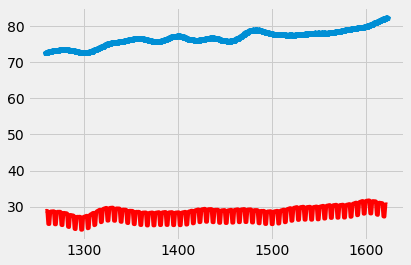

In [168]:
point_forecast_oil = forecast_oil[-365:]
point_forecast_pcar = forecast_pcar[-365:]
plt.plot(point_forecast_oil["yhat"], 'r')
plt.plot(point_forecast_pcar["yhat"], 'p')

/Users/markconrad/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100).corr(other=<Series>)
  if __name__ == '__main__':


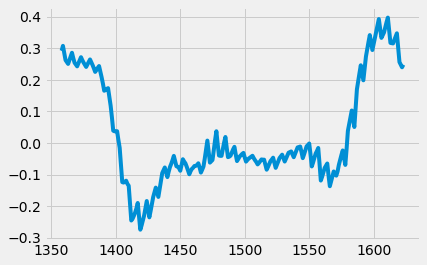

In [169]:
plt.plot(pd.rolling_corr(point_forecast_oil["yhat"],point_forecast_pcar["yhat"],100))